# RBP sequence data exploration

The goal of this notebook is to explore RBP sequence data in depth. Besides general data exploration, the idea is to provide a detailed look at how the RBPs are composed of different building blocks and shed a light on how much diversity or conservation exists among these building blocks.

There is however, one important disctinction to keep in mind: for the ML-based RBP detection work the emphasis is on discovering how these RBPs differ from non-RBPs, while for interaction prediction the empasis should be on how RBPs differ between and within species. Nevertheless, some of the analyses can work in both types of explorations, as a central question is: how diverse are the RBPs? Phrased differently, what types of modular builds do we encounter?

1. As a start, pairwise alignments are computed; both for the entire RBP sequences as well as their N- and C-terminal parts. The identity% will serve as a basis for various subsequent analyses.

2. A general overview of the data is given by plotting the number of sequences in the dataset below a certain threshold for identity%. In addition, a table is constructed that summarizes the number of sequences per species (or top10), the length of longest and shortest sequence and the highest and lowest identity% within each species.

3. Histograms of the identity% are plotted for the N-terminus and C-terminus for each species (or top10) to get an additional feeling of how conserved or diverse the N/C-terminal parts are within each species.

4. Focusing more on the building blocks, a general overview of the different building blocks is constructed by plotting a heatmap of counts of the different building blocks (from our curated list).

5. Further zooming in on the domains, we construct circos graphs visualizing the N- or C-terminal combinations in the different species. Visually, this answers the question of how modules are related within and accross the species (which building blocks are shared.

### 0 - Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import explore_utils as exu
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from chord import Chord
from tqdm.notebook import tqdm
from plots2 import CircosPlot
%matplotlib inline

### 1 - Load data & set paths

In [2]:
RBPs = pd.read_csv('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/RBPbase_230421.csv')
RBPalign = np.loadtxt('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/RBP_alignmentmatrix.txt')
RBPalignN = np.loadtxt('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/RBP_alignmentmatrix_Nterm.txt')
RBPalignC = np.loadtxt('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/RBP_alignmentmatrix_Cterm.txt')

In [3]:
hmm_path = '/opt/anaconda3/pkgs/hmmer-3.1b2-0/bin'
pfam_db = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/Pfam-A_extended.hmm'

In [4]:
RBPs.shape

(4211, 5)

### 2 - General overview of the data

##### Translate proteins and add to dataframe (do only once)

##### Overview table

In [5]:
species = ['enterococcus_faecium', 'staphylococcus_aureus', 'klebsiella_pneumoniae', 'acinetobacter_baumannii', 
          'pseudomonas_aeruginosa', 'enterobacter_cloacae', 'enterobacter_aerogenes']
number = []; shortest = []; longest = []; average = []; minperc = []; maxperc = []

for sp in species:
    sequences = RBPs.protein_seq[RBPs.host == sp]
    protein_lengths = [len(seq) for seq in sequences]
    shortest.append(min(protein_lengths))
    longest.append(max(protein_lengths))
    average.append(round(np.mean(protein_lengths), 2))
    number.append(sum(RBPs.host == sp))
    
    indices = RBPs.host == sp
    #RBPsub = RBPalign[indices, :][:,indices]
    #minperc.append(round(np.min(RBPsub), 3))
    minperc.append(round(np.min(RBPalign), 3))
    maxperc.append(round(np.max(RBPalign), 3))
    #maxperc.append(round(np.max(RBPsub), 3))

RBPdf = pd.DataFrame({'number_of_hits':number, 'shortest_length':shortest, 'longest_length':longest, 
                       'average_length':average, 'minimum_%id':minperc, 'maximum_%id':maxperc})
RBPdf.index = species
RBPdf

,number_of_hits,shortest_length,longest_length,average_length,minimum_%id,maximum_%id
enterococcus_faecium,393,34,965,596.29,0.13,1.0
staphylococcus_aureus,1514,42,1086,518.19,0.13,1.0
klebsiella_pneumoniae,1663,29,4356,800.42,0.13,1.0
acinetobacter_baumannii,74,43,1099,529.00,0.13,1.0
pseudomonas_aeruginosa,396,53,1257,693.38,0.13,1.0
enterobacter_cloacae,129,41,1404,717.10,0.13,1.0
enterobacter_aerogenes,42,143,3108,734.71,0.13,1.0


There appear to still be some very short sequences in the database but also some very long sequences (these lengths are at the protein level). We will further examine these outliers first and then filter them from the database.

##### Further preprocessing for outliers

In [9]:
count_small = 0
count_large = 0
pr_lens = []
for sequence in RBPs.protein_seq:
    pr_lens.append(len(sequence))
    if len(sequence) < 200:
        count_small += 1
    elif len(sequence) > 2500:
        count_large += 1
        #print(sequence)
print('number of small ones:', count_small)
print('number of large ones:', count_large)

number of small ones: 136
number of large ones: 103


BLASTing a random subset of the large ones, we find that all of them contain DUF1983, a domain we have condisered as a chaperone domain. However, it might not be best to include proteins as RBPs if they ONLY contain a chaperone domain. Looking again at Pfam however, we do mostly find hits that point to RBPs. So we'll move along with them but filter out the small and large ones.

(array([ 44.,  18.,  35.,  40.,  31., 266., 137., 372., 355., 137., 317.,
        245.,  84., 675., 184., 230., 189., 137.,  41.,  85.,  86.,  20.,
        185.,  12.,  21.,  11.,  50.,  72.,  16.,   7.,   1.,   3.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          1.,   3.,   2.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   2.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,   7.,  65.,   0.,
          1.]),
 array([  29.  ,   72.27,  115.54,  158.81,  202.08,  245.35,  288.62,
         331.89,  375.16,  418.43,  461.7 ,  504.97,  548.24,  591.51,
         634.78,  678.05,  721.32,  764.59,  807.86,  851.13,  894.4 ,
         937.67,  980.94, 1024.21, 1067.48, 1110.75, 1154.02, 1197.29,
        1240.56, 1283.83, 1327.1 ,

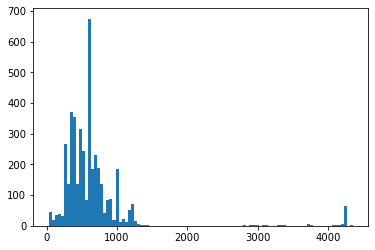

In [7]:
plt.hist(pr_lens, bins=100)

Clearly, all sequences with a length above 2000 should be viewed as outliers. The histogram peaks at around 380 and 551 AAs, and dies down at around 1400 AAs. Then some outliers occur at around 3000-4000. Also, there's a clear drop in sequences occuring below 205 AAs. Which is kind of what we would expect from a biology standpoint. So we'll put two filters at 250 (conservative) and 1500.

In [6]:
to_delete = []
for i, sequence in enumerate(RBPs.protein_seq):
    if (len(sequence) < 250) or (len(sequence) > 1500):
        to_delete.append(i)
        
RBPs = RBPs.drop(to_delete)
RBPs = RBPs.reset_index(drop=True)
RBPalign = np.delete(RBPalign, to_delete, 0)
RBPalign = np.delete(RBPalign, to_delete, 1)
RBPalignN = np.delete(RBPalignN, to_delete, 0)
RBPalignN = np.delete(RBPalignN, to_delete, 1)
RBPalignC = np.delete(RBPalignC, to_delete, 0)
RBPalignC = np.delete(RBPalignC, to_delete, 1)

RBPs.shape
RBPalign.shape

(3933, 3933)

##### Plot number of sequences vs. threshold

In [21]:
thresholds = np.linspace(1.0, 0.5, 11)
RBPmatrix = RBPalign.copy()
np.fill_diagonal(RBPmatrix, 0) # exclude comparing the sequences themselves
total_number_seqs = []
for thres in thresholds:
    row = 0
    while row < RBPmatrix.shape[0]:
        if np.any(RBPmatrix[row,:] > thres):
            RBPmatrix = np.delete(RBPmatrix, row, 0)
            RBPmatrix = np.delete(RBPmatrix, row, 1)
        row += 1
    total_number_seqs.append(RBPmatrix.shape[0])
    print(thres, 'done!')

1.0 done!
0.95 done!
0.9 done!
0.85 done!
0.8 done!
0.75 done!
0.7 done!
0.6499999999999999 done!
0.6 done!
0.55 done!
0.5 done!


In [22]:
total_number_seqs

[3933, 2100, 1170, 708, 484, 367, 315, 269, 247, 224, 203]

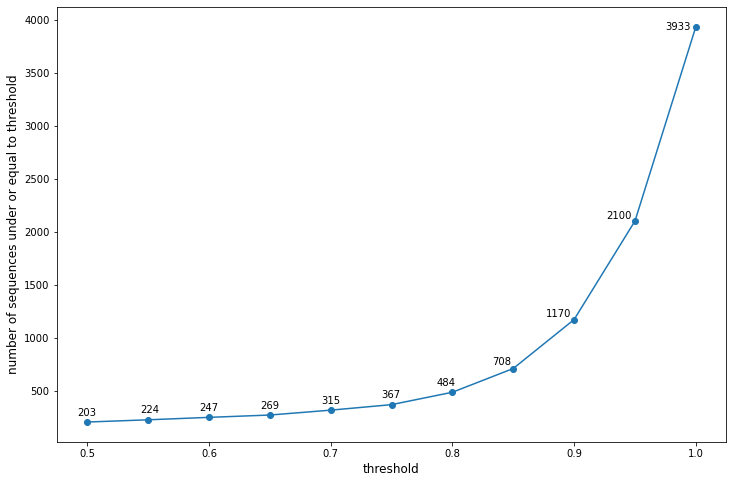

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(thresholds, total_number_seqs, marker='o')
ax.set_xlabel('threshold', size=12)
ax.set_ylabel('number of sequences under or equal to threshold', size=12)
ax.annotate('3933', (0.975, 3900))
ax.annotate('2100', (0.926, 2120))
ax.annotate('1170', (0.877, 1200))
ax.annotate('708', (0.833, 745))
ax.annotate('484', (0.787, 550))
ax.annotate('367', (0.742, 430))
ax.annotate('315', (0.692, 380))
ax.annotate('269', (0.642, 330))
ax.annotate('247', (0.592, 310))
ax.annotate('224', (0.544, 290))
ax.annotate('203', (0.492, 260))

fig.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/sequences_per_threshold.png', dpi=400)

We clearly see that, as thresholds decrease, a significant number of sequences is quickly discarded from the dataset. This means that overal conservation in the dataset is high. A plateau is reached at about 65-70%, which is higher than what we would've expected (functional conservation at <50% for modular proteins according to Addou et al). It also eludes to the observation that relatively small changes in the sequences would be able to shift host spectrum (at least intra species). Finally, this result also reflects the way we have constructed the database: by sequence similarity. However, we might have expected that HMMs are more sensitive than simple alignment and would have resulted in a more diverse set of RBPs.

The interesting follow-up question is: does this conservation also translate to the bacterial receptors that are targeted by these RBPs? Or are the receptors more diverse, indicating that subtle changes in the RBP sequence can lead to more diverse target of the bacterial receptor. How will we deal with this in a pairwise learning context?

### 3 - Histograms of N-terminal and C-terminal conservation

Here, the idea is to get a sense of the conservation of the RBPs both at the N-terminus and C-terminus across the genera or species. The goal is to plot two histograms of the identity%, per genus/species: one for the N-terminus and one for the C-terminus

In [30]:
# Process data into dataframe
np.fill_diagonal(RBPalignN, 0)
np.fill_diagonal(RBPalignC, 0)
displot_data = {'identity_perc': [], 'species': [], 'terminus': []}

for i in range(RBPalign.shape[0]-1):
    species_i = RBPs.host[i]
    for j in range(i, RBPalign.shape[1]): # from i to prevent counting doubles
        species_j = RBPs.host[j]
        if species_i == species_j:
            # Nterm
            displot_data['identity_perc'].append(RBPalignN[i,j])
            displot_data['species'].append(species_i)
            displot_data['terminus'].append('N')

            # Cterm
            displot_data['identity_perc'].append(RBPalignC[i,j])
            displot_data['species'].append(species_i)
            displot_data['terminus'].append('C')
displot_data = pd.DataFrame(displot_data)

Histogram of observed identity percentage within species enterococcus_faecium
Histogram of observed identity percentage within species staphylococcus_aureus
Histogram of observed identity percentage within species klebsiella_pneumoniae
Histogram of observed identity percentage within species acinetobacter_baumannii
Histogram of observed identity percentage within species pseudomonas_aeruginosa
Histogram of observed identity percentage within species enterobacter_cloacae
Histogram of observed identity percentage within species enterobacter_aerogenes


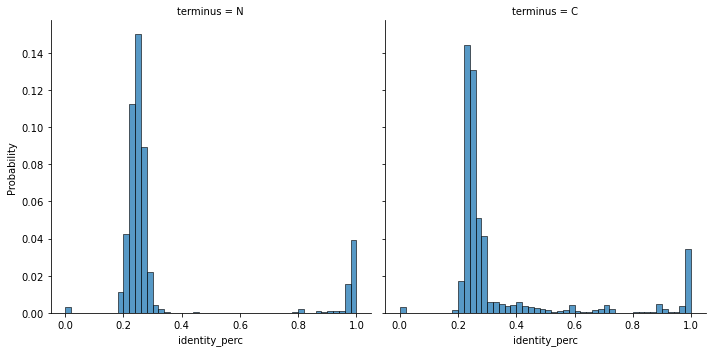

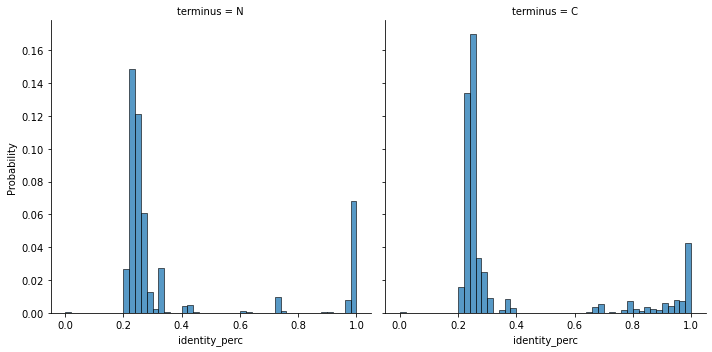

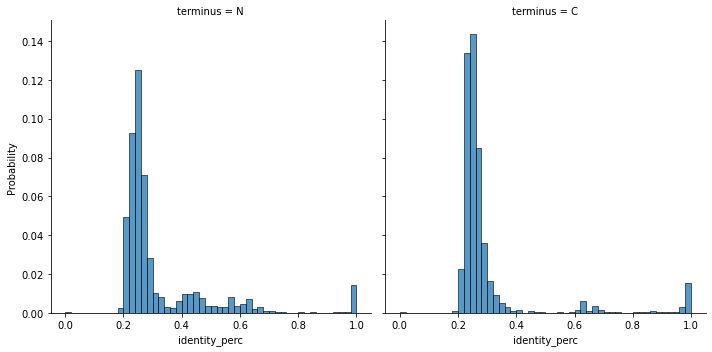

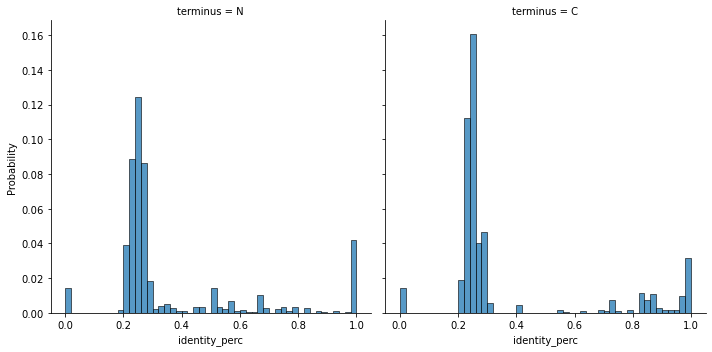

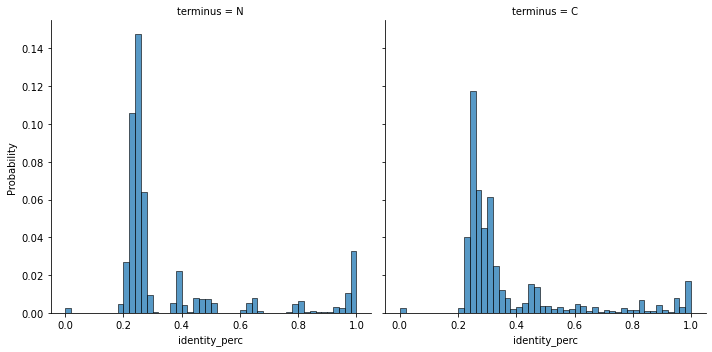

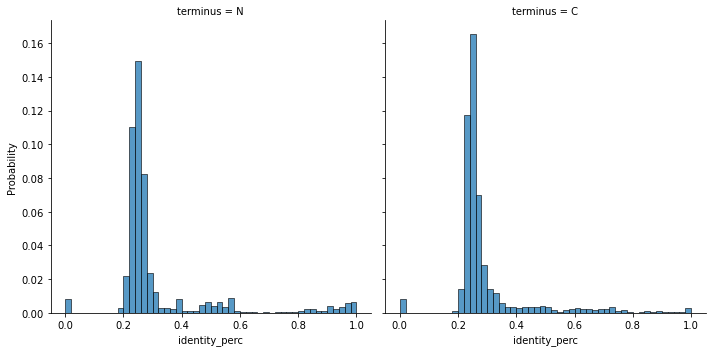

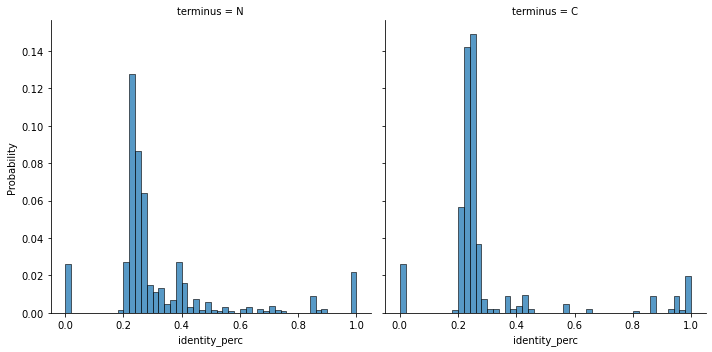

In [31]:
# visualize histograms
%matplotlib inline
species = ['enterococcus_faecium', 'staphylococcus_aureus', 'klebsiella_pneumoniae', 'acinetobacter_baumannii', 
          'pseudomonas_aeruginosa', 'enterobacter_cloacae', 'enterobacter_aerogenes']
for sp in species:
    indices = displot_data.species == sp
    displot_sub = displot_data.loc[indices,:]
    print('Histogram of observed identity percentage within species '+sp)
    sns.displot(data=displot_sub, x='identity_perc', col='terminus', stat='probability', bins=50)

### 4 -  RBP building blocks

In this section, we try to visualize the different building blocks of RBPs we have identified in previous work and look at their occurrence (= counts) across the species (using a heatmap).

*Heatmap without MillardLab RBPs*

In [7]:
# define the paths and RBP building blocks (first all N-term, then C-term, then chaps)
blocks = ['Phage_T7_tail','Tail_spike_N','Prophage_tail','BppU_N','Mtd_N','Head_binding','DUF3751','End_N_terminal', 
           'phage_tail_N','Prophage_tailD1','DUF2163','Phage_fiber_2','phage_RBP_N1','phage_RBP_N4','phage_RBP_N26',
           'phage_RBP_N28','phage_RBP_N34','phage_RBP_N45', 'other_N', 'unknown_N',
           'Lipase_GDSL_2','Pectate_lyase_3','gp37_C','Beta_helix','Gp58','End_beta_propel','End_tail_spike', 
           'End_beta_barrel','PhageP22-tail','Phage_spike_2','gp12-short_mid','Collar', 'phage_RBP_C2', 
           'phage_RBP_C10','phage_RBP_C24','phage_RBP_C43','phage_RBP_C59','phage_RBP_C60','phage_RBP_C62',
            'phage_RBP_C67','phage_RBP_C79','phage_RBP_C97','phage_RBP_C111','phage_RBP_C115','phage_RBP_C120',
            'phage_RBP_C126','phage_RBP_C138','phage_RBP_C143','phage_RBP_C157','phage_RBP_C164','phage_RBP_C175',
            'phage_RBP_C180','phage_RBP_C205','phage_RBP_C217','phage_RBP_C220','phage_RBP_C221','phage_RBP_C223',
            'phage_RBP_C234','phage_RBP_C235','phage_RBP_C237','phage_RBP_C249','phage_RBP_C259','phage_RBP_C267',
            'phage_RBP_C271','phage_RBP_C277','phage_RBP_C281','phage_RBP_C292','phage_RBP_C293','phage_RBP_C296', 
            'phage_RBP_C300','phage_RBP_C301','phage_RBP_C319','phage_RBP_C320','phage_RBP_C321','phage_RBP_C326', 
            'phage_RBP_C331','phage_RBP_C337','phage_RBP_C338','phage_RBP_C340',
           'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672', 'other_C', 'unknown_C']

# initialize dict
map_dict = {'enterococcus_faecium': [0]*len(blocks),'staphylococcus_aureus': [0]*len(blocks), 
               'klebsiella_pneumoniae': [0]*len(blocks), 'acinetobacter_baumannii': [0]*len(blocks),
               'pseudomonas_aeruginosa': [0]*len(blocks), 'enterobacter_cloacae': [0]*len(blocks), 
               'enterobacter_aerogenes': [0]*len(blocks)}

# loop over every species and make dict of counts of every block (incl 'other')
loc_otherN = blocks.index('other_N')
loc_otherC = blocks.index('other_C')
loc_unknownN = blocks.index('unknown_N')
loc_unknownC = blocks.index('unknown_C')
bar = tqdm(total=len(RBPs.sequence), leave=True)
for i, sequence in enumerate(RBPs['sequence']):
    host = RBPs['host'][i]
    domains, scores, biases, ranges = exu.gene_domain_scan(hmm_path, pfam_db, [sequence], threshold=18)
    unknown_N = 0
    unknown_C = 0
    # loop over hits and count the significants in the correct key of the dictionary
    for j, dom in enumerate(domains):
        OM_score = math.floor(math.log(scores[j], 10)) # order of magnitude
        OM_bias = math.floor(math.log(biases[j]+0.00001, 10))
        # add building block domain at correct location
        if (OM_score > OM_bias) and (dom in blocks):
            location = blocks.index(dom)
            if (location <= loc_unknownN):
                unknown_N += 1
                map_dict[host][location] += 1
            elif (location > loc_unknownN) and (scores[j] >= 25): # C-terminals over 25
                unknown_C += 1
                map_dict[host][location] += 1
        # add other_N domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] < 200):
            map_dict[host][loc_otherN] += 1
            unknown_N += 1
        # add other_C domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] >= 200) and (scores[j] >= 25):
            map_dict[host][loc_otherC] += 1
            unknown_C += 1
    # add counts if no known domain was found
    if unknown_N == 0:
        map_dict[host][loc_unknownN] += 1
    elif unknown_C == 0:
        map_dict[host][loc_unknownC] += 1
    bar.update(1)
bar.close()
    
# convert dict to matrix and normalize to plot as heatmap (rows = species, cols = building blocks)
map_df = pd.DataFrame.from_dict(map_dict)
map_array = np.asarray(map_df).T
map_array_N = map_array[:,:loc_unknownN+1]
map_array_C = map_array[:,loc_unknownN+1:]
print('test dimensions:', map_array.shape[1] == (map_array_N.shape[1]+map_array_C.shape[1]))

# split and normalize N/C separately, then concat again
map_array_N = map_array_N/map_array_N.sum(axis=1, keepdims=1)
map_array_C = map_array_C/map_array_C.sum(axis=1, keepdims=1)
map_array = np.concatenate((map_array_N, map_array_C), axis=1)
map_array.shape

  0%|          | 0/3933 [00:00<?, ?it/s]

test dimensions: True


(7, 87)

In [22]:
# new clusters
pd.DataFrame(map_array_C, columns=blocks[20:])[['phage_RBP_C120', 'phage_RBP_C143', 'phage_RBP_C175', 'phage_RBP_C221', 'phage_RBP_C234', 'phage_RBP_C237', 'phage_RBP_C271', 'phage_RBP_C277']]

,phage_RBP_C120,phage_RBP_C143,phage_RBP_C175,phage_RBP_C221,phage_RBP_C234,phage_RBP_C237,phage_RBP_C271,phage_RBP_C277
0,0.164201,0.16716,0.000000,0.000000,0.023669,0.023669,0.000000,0.000000
1,0.000000,0.00000,0.119203,0.237639,0.000000,0.000000,0.236489,0.119203
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


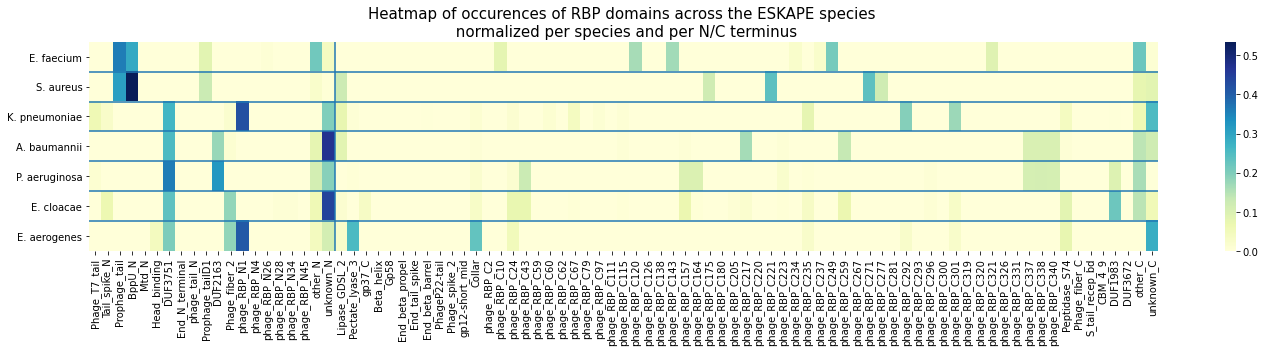

In [10]:
fig, ax = plt.subplots(figsize=(20,5))
xticks = blocks
yticks = ['E. faecium', 'S. aureus', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'E. cloacae', 'E. aerogenes']
sns.heatmap(map_array, cmap='YlGnBu', xticklabels=xticks, yticklabels=yticks)
ax.hlines([1, 2, 3, 4, 5, 6], *ax.get_xlim())
ax.vlines([loc_unknownN+1], *ax.get_ylim())
ax.set_title('Heatmap of occurences of RBP domains across the ESKAPE species \n normalized per species and per N/C terminus', size=15)
plt.tight_layout()
fig.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/prophages_domains_heatmap_thr18.png', dpi=400)

*Heatmap with MillardLab RBPs included*

In [16]:
milrbps = pd.read_csv('/Users/Dimi/GoogleDrive/PhD/3_WP1_PHAGEBASE/32_DATA/MillardLab_RBPs.csv', sep='\t')
to_delete = [index for index, name in enumerate(milrbps['ProteinName']) if 'attachment' in name]
milrbps.drop(index=to_delete, inplace=True)
milrbps.reset_index(inplace=True)

In [17]:
mil_df = pd.DataFrame({'phage_nr': [999]*milrbps.shape[0], 'host': milrbps.Host, 'host_accession': milrbps.Accession,
                      'sequence': milrbps.DNASeq, 'protein_seq': milrbps.ProteinSeq})
RBPs = pd.concat([RBPs, mil_df], axis=0, ignore_index=True)

In [18]:
# define the paths and RBP building blocks (first all N-term, then C-term, then chaps)
blocks = ['Phage_T7_tail','Tail_spike_N','Prophage_tail','BppU_N','Mtd_N','Head_binding','DUF3751','End_N_terminal', 
           'phage_tail_N','Prophage_tailD1','DUF2163','Phage_fiber_2','phage_RBP_N1','phage_RBP_N4','phage_RBP_N26',
           'phage_RBP_N28','phage_RBP_N34','phage_RBP_N45', 'other_N', 'unknown_N',
           'Lipase_GDSL_2','Pectate_lyase_3','gp37_C','Beta_helix','Gp58','End_beta_propel','End_tail_spike', 
           'End_beta_barrel','PhageP22-tail','Phage_spike_2','gp12-short_mid','Collar', 'phage_RBP_C2', 
           'phage_RBP_C10','phage_RBP_C24','phage_RBP_C43','phage_RBP_C59','phage_RBP_C60','phage_RBP_C62',
            'phage_RBP_C67','phage_RBP_C79','phage_RBP_C97','phage_RBP_C111','phage_RBP_C115','phage_RBP_C120',
            'phage_RBP_C126','phage_RBP_C138','phage_RBP_C143','phage_RBP_C157','phage_RBP_C164','phage_RBP_C175',
            'phage_RBP_C180','phage_RBP_C205','phage_RBP_C217','phage_RBP_C220','phage_RBP_C221','phage_RBP_C223',
            'phage_RBP_C234','phage_RBP_C235','phage_RBP_C237','phage_RBP_C249','phage_RBP_C259','phage_RBP_C267',
            'phage_RBP_C271','phage_RBP_C277','phage_RBP_C281','phage_RBP_C292','phage_RBP_C293','phage_RBP_C296', 
            'phage_RBP_C300','phage_RBP_C301','phage_RBP_C319','phage_RBP_C320','phage_RBP_C321','phage_RBP_C326', 
            'phage_RBP_C331','phage_RBP_C337','phage_RBP_C338','phage_RBP_C340',
           'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672', 'other_C', 'unknown_C']

# initialize dict
map_dict = {'enterococcus_faecium': [0]*len(blocks),'staphylococcus_aureus': [0]*len(blocks), 
               'klebsiella_pneumoniae': [0]*len(blocks), 'acinetobacter_baumannii': [0]*len(blocks),
               'pseudomonas_aeruginosa': [0]*len(blocks), 'enterobacter_cloacae': [0]*len(blocks), 
               'enterobacter_aerogenes': [0]*len(blocks), 'MillardLab_RBPs': [0]*len(blocks)}

# loop over every species and make dict of counts of every block (incl 'other')
loc_otherN = blocks.index('other_N')
loc_otherC = blocks.index('other_C')
loc_unknownN = blocks.index('unknown_N')
loc_unknownC = blocks.index('unknown_C')
bar = tqdm(total=len(RBPs.sequence), leave=True)
for i, sequence in enumerate(RBPs['sequence']):
    host = RBPs['host'][i]
    domains, scores, biases, ranges = exu.gene_domain_scan(hmm_path, pfam_db, [sequence], threshold=18)
    unknown_N = 0
    unknown_C = 0
    # loop over hits and count the significants in the correct key of the dictionary
    for j, dom in enumerate(domains):
        # order of magnitude
        OM_score = math.floor(math.log(scores[j], 10))
        OM_bias = math.floor(math.log(biases[j]+0.00001, 10))
        # add building block domain at correct location
        if (OM_score > OM_bias) and (dom in blocks):
            location = blocks.index(dom)
            if host in map_dict.keys():
                if location <= loc_unknownN:
                    map_dict[host][location] += 1
                    unknown_N += 1
                elif (location > loc_unknownN) and (scores[j] >= 25):
                    map_dict[host][location] += 1
                    unknown_C += 1
            else:
                if location <= loc_unknownN:
                    map_dict['MillardLab_RBPs'][location] += 1
                    unknown_N += 1
                elif (location > loc_unknownN) and (scores[j] >= 25):
                    map_dict['MillardLab_RBPs'][location] += 1
                    unknown_C += 1
        # add other_N domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] < 200):
            if host in map_dict.keys():
                map_dict[host][loc_otherN] += 1
            else:
                map_dict['MillardLab_RBPs'][loc_otherN] += 1
            unknown_N += 1
        # add other_C domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] >= 200) and (scores[j] >= 25):
            if host in map_dict.keys():
                map_dict[host][loc_otherC] += 1
            else:
                map_dict['MillardLab_RBPs'][loc_otherC] += 1
            unknown_C += 1
    # add counts if no known domain was found
    if unknown_N == 0:
        if host in map_dict.keys():
            map_dict[host][loc_unknownN] += 1
        else:
            map_dict['MillardLab_RBPs'][loc_unknownN] += 1
    elif unknown_C == 0:
        if host in map_dict.keys():
            map_dict[host][loc_unknownC] += 1
        else:
            map_dict['MillardLab_RBPs'][loc_unknownC] += 1
    bar.update(1)
bar.close()
    
# convert dict to matrix and normalize to plot as heatmap (rows = species, cols = building blocks)
map_df = pd.DataFrame.from_dict(map_dict)
map_array = np.asarray(map_df).T
map_array_N = map_array[:,:loc_unknownN+1]
map_array_C = map_array[:,loc_unknownN+1:]
print('test dimensions:', map_array.shape[1] == (map_array_N.shape[1]+map_array_C.shape[1]))

# split and normalize N/C separately, then concat again
map_array_N = map_array_N/map_array_N.sum(axis=1, keepdims=1)
map_array_C = map_array_C/map_array_C.sum(axis=1, keepdims=1)
map_array = np.concatenate((map_array_N, map_array_C), axis=1)
map_array.shape

  0%|          | 0/8899 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


test dimensions: True


(8, 87)

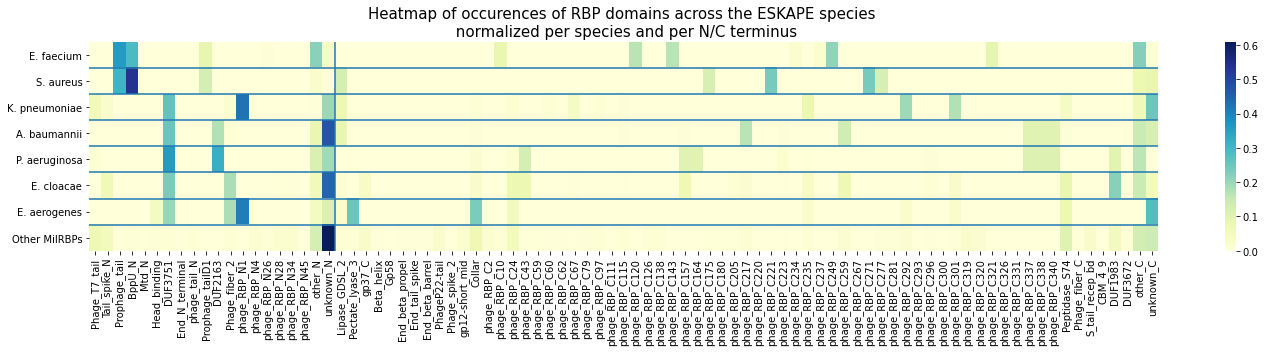

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
xticks = blocks
yticks = ['E. faecium', 'S. aureus', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'E. cloacae', 'E. aerogenes', 'Other MilRBPs']
sns.heatmap(map_array, cmap='YlGnBu', xticklabels=xticks, yticklabels=yticks)
ax.hlines([1, 2, 3, 4, 5, 6, 7], *ax.get_xlim())
ax.vlines([20], *ax.get_ylim())
ax.set_title('Heatmap of occurences of RBP domains across the ESKAPE species \n normalized per species and per N/C terminus', size=15)
plt.tight_layout()
fig.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/allRBPs_domains_heatmap.png', dpi=400)

The heatmap of normalized count (P(domain ¡ host)) looks somewhat better than when we display absolute counts. In addition, we have normalized all of the building blocks of the N-terminus separately from the one of the C-terminus. This allows us to more easily appreciate how the building blocks at the N-terminus are distributed and those at the C-terminus (because these are two separate distributions of course! = mosaicism). 

Looking at the N-terminus, the first thing we notice is two groups (E. faecium + S. aureus) that are characterized by the proportionally equal occurence of Prophage_tail and BppU_N; and the other species that are characterized by the occurence of DUF3751 together with DUF2163 or Phage_fiber_2. Overall, not many of the N-terminal blocks are 'other_N', meaning protein domains that occur but that we haven't (manually) identified to be related to RBPs. In addition, we see some unknown blocks, particularly present at the C-terminus for E. faecium and S. aureus. A. baumannii also exhibits some unknown blocks but here at the N-terminus.

Looking at the C-terminus, we see that E. faecium mostly has other C-terminal domains (which we also noticed on the first network-style visualization we made), which in a sense is weird because this should have been 'dealt with' at the stage of the RBP detection: we have attempted to discover unknown N/C termini and clustering them to construct new HMMs. If E. faecium sequences weren't included in these new HMMs, it is because they appeared in clusters that were too small (less than 5 entries per cluster). Indeed, in of the 347 C-terminal clusters that were identified, only 47 (=13.5%) of them contained more than 5 sequences. S. aureus looks very binary at the C-terminus: either Lipase_GDSL_2 or some other domain(s). K. pneumoniae and P. aeruginosa and mostly E. aerogenes as well seem pretty much equally distributed (indeed, we observed before that many of the in-house constructed HMMs match K. pneumoniae and P. aeruginosa sequences). A. baumannii also matches some of these constructed HMMs but in a much more sparse way (most matches with phage_RBP_C296, some with phage_RBP_C220 and phage_RBP_C10).

UPDATE 15/04

The picture at the C-terminus improved for E. faecium, but for S. aureus we still have most C-terminal ends unknown. This means that C-terminal ends that do not share a known domain are too dissimilar to be taken up into HMMs (cfr. cluster of >=5 members). But does this make sense? Above, we do see the histograms of the C-terminal ends, in which there are sequences that share 70+% identity. So for these not to be involved in clusters, they must have a known C-terminal end.

UPDATE 16/04

Something we also notice is that for K. pneumoniae, A. baumannii and E. cloacae, most of the N-terminal blocks are also unknown! Would the reason for this be similar to the S. aureus C-terminal unknowns? In general, over all species, we see that our constructed N-terminal HMMs have not picked up any of the sequences in the set... Not finding many hits for the species that have a lot of other KNOWN N-terminal blocks is expected (e.g. E. faecium and S. aureus and even P. aeruginosa). But the ones with the majority of unknown blocks is weird. Because these are the ones that you would expect to be in the HMM construction, and thus those that you would want to find. Same for S. aureus at the C-terminus.

The size of the clusters does not seem to be of influence, because the big N_28 cluster has 79 sequences in it but doesn't find anything here! Looking in detail at the HMM hits of N_28, we find 13 hits in the database, but all of them with a score < 25 (don't pass the threshold). Most of them are in the range of 12-14 scores. And still, it is remarkable that from a profile of 79 sequences (those same sequences), that only 13 of them are picked up afterwards.

One potential explanation for the N-terminals: because we see that at the C-terminus, this problem doesn't occur, it might have to do with the length of the profiles. More specifically, shorter sequences lead to lower scores (while still 'significant' hits)

CONCLUSIONS:
- The heatmap is not a complete picture, as we filter some of the newly constructed HMMs out of precaution (suspicious annotations).
- While it is true that most clusters have only one member, and thus we don't see them in the HMM construction, this only represents 16.6% of the sequences in all of the clusters. Meaning: there are some cluster that have a substantial amount of sequences in them (50+). From a sequence perspective, we still include +75% of the C-terminal ends in the HMMs.
- The S. aureus sequences are thus not all unique or much more diverse than the other species. It's because they were in cluster C_221, which got filtered.
- The known C-terminal building blocks don't occur very often, but this has been the case throughout all the iterations, this is not new.
- The strange last thing, is the newly constructed N-terminals. This partly has to do with cluster N_1 that got filtered, but we've also noticed strange behaviour for e.g. N_28, which has 79 members but afterwards only finds 13 hits that are all filtered under the score threshold... **remaining question: why does a profile built with unknown sequences at first not find those after it is built?** Versus: cluster 1 only containing 7 sequences and then detecting a loooot of new hits?!
- We've trained HMMs on MillardLab RBPs as well, explains why some models have no hits whatsoever!

UPDATE 30/04

After adding the new HMMs to Pfam extended and appropriately renaming these HMMs, we see a result that we expect. The unknowns for S. aureus are gone, and spread out accross the HMMs that we hadn't included before. Now we do notice 'many' unknown hits at the N-terminus, for E. cloacae and A. baumannii, but this is misleading as it is shown in a heatmap! Previously, the largest values on the heatmap were 0.8, while now this is only 0.5. So colors can't be compared to previously constructed heatmaps. In general, we wouls expect a little more hits as we've lowered the threshold for N-terminal HMMs from 25 to 18. But ofcourse, we can not make hard conclusions based on the heatmap, because it only shows frequencies, not absolute numbers. 

The fact that we do see quite a lot of unknowns (especially for A. baumannii and E. cloacae), we can pose the question whether more novel HMMs could additionally be constructed for the N-terminus (because now, we have included all of the HMMs that we have already constructed).

UPDATE 03/05

What is a good precision here? A good precision would be if we only include a sequence if:

1. the sequence has at least one known Pfam RBP-related domain (not custom built by us) at either N- or C-terminus, in combination with either a custom built HMM or an other domain or an unknown.
2. the sequence has a combination of custom built HMMs, both of which ALSO occur in combination with known Pfam RBP domains.

Hypothesis: in HMMs built with many sequences, some of the 'signal' of a subpart of the sequences may get lost (signal-to-noise ratio) due to the presence of the other sequences, which leads to insignificant hits.

We see a lot of hits in cluster C_221, but this is one that we have discarded based on suspicious annotation! The same might be true for cluster N_1, which was also discarded but often had hits related to Klebsiella and Acinetobacter...

Text(0, 0.5, 'number of occurences')

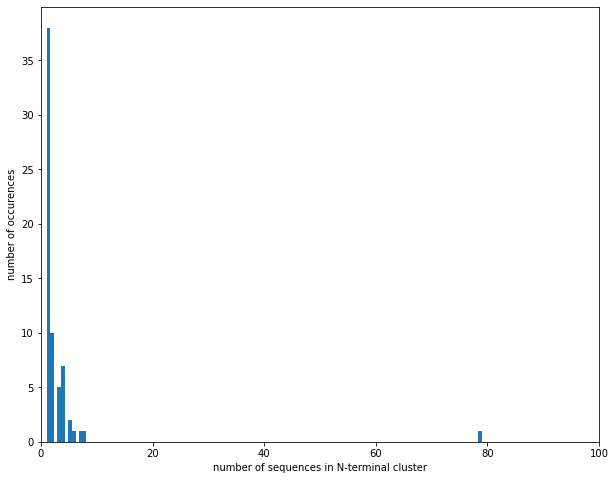

In [5]:
# histogram of number of sequences in the clusters
dom_path = '/Users/Dimi/GoogleDrive/PhD/3_WP1_PHAGEBASE/32_DATA/RBP_detection/clusters' 
clusters_unknown_C = open(dom_path+'/'+ 'unknown_N_termini.clstr')
cluster_count = 0
cluster_sizes = []
for line in clusters_unknown_C.readlines():
    # new cluster
    if line[0] == '>':
        cluster_sizes.append(cluster_count)
        cluster_count = 0
    # in a cluster -> count sequence
    else:
        cluster_count += 1
cluster_sizes.pop(0) # delete first artifact

# make histogram
fig, ax = plt.subplots(figsize=(10,8))
plt.hist(cluster_sizes, bins=120)
plt.xlim(0, 100)
plt.xlabel('number of sequences in N-terminal cluster')
plt.ylabel('number of occurences')
#plt.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/cluster40_size_histogram.png', dpi=400)

In [4]:
# proportion of sequences that reside in a singular cluster (size 1)
(cluster_sizes.count(1)+cluster_sizes.count(2)+cluster_sizes.count(3)+cluster_sizes.count(4))/ sum(cluster_sizes)

0.2843601895734597

In [ ]:
# see how many E faecium and S aureus sequences in the different clusters
# {cluster_size: species_sequences}
#indices = [index for index, sequence in enumerate(genebase.sequence) if cluster_sequence in str(Seq(sequence).translate()[:-1])]
genebase = pd.read_csv('/Users/Dimi/GoogleDrive/PhD/3_WP1_PHAGEBASE/32_DATA/PhageGeneBase.csv')
entero_indices = genebase.host == 'enterococcus_faecium'
staph_indices = genebase.host == 'staphylococcus_aureus'
enteros = genebase.sequence[entero_indices]
staphs = genebase.sequence[staph_indices]

# get the sequences
input_file = dom_path+'/'+ 'unknown_C_cutsequences.fasta'
sequence_list = []
for record in SeqIO.parse(input_file, 'fasta'): # get sequences in a list
    sequence_list.append(str(record.seq))
    
clusters_unknown_C = open(dom_path+'/'+ 'unknown_C_termini.clstr')
for line in clusters_unknown_C.readlines():
    if line[0] == '>':
        # finish old cluster if not the first one
        if (cluster_iter > 0):
            staph_counts = sum([1 for ])
            
            
            
            fasta = open(dom_path+'/'+'unknown_C_termini_cluster_'+str(cluster_iter)+'.fasta', 'w')
            for i, seq in enumerate(cluster_sequences):
                index = cluster_indices[i]
                fasta.write('>sequence'+index+'\n'+seq+'\n')
            fasta.close()
        # initiate new cluster
        cluster_sequences = []
        cluster_indices = []
        cluster_iter += 1
    # in a cluster
    else:
        current_index = re.search('>sequence_[0-9]+', line).group(0).split('sequence_')[1]
        current_sequence = sequence_list[int(current_index)]
        cluster_indices.append(current_index)
        cluster_sequences.append(current_sequence)

The heatmap is interesting, and shows us how different building blocks occur across the species. But it doesn't show us how different combinations of building blocks occur, from which we could infer:
1. how combinations differ accross species
2. which (predicted) HGT events have occurred

This is why the next section focuses on constructing bipartite graphs and/or chord diagrams that illustrate the occurences of the building blocks as well as which combinations of them occur (per species).

### 5 - RBP cluster graph & building blocks

For simplicity, we concat the chaperone domains with the binding domains (we're interested in HGTs between N- and C-terminus). High scoring interactions linked to nodes of high degree, can indicate particularly important interactions in the network. Can we identify differences in 'importance interactions' (= important domain combos here), that differ among the species?!

RERUN RBP set first to exclude MillardLab RBPs!

100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


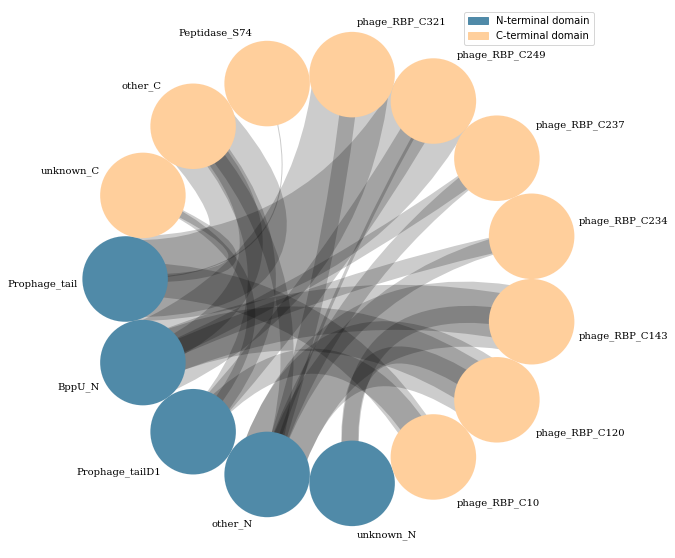

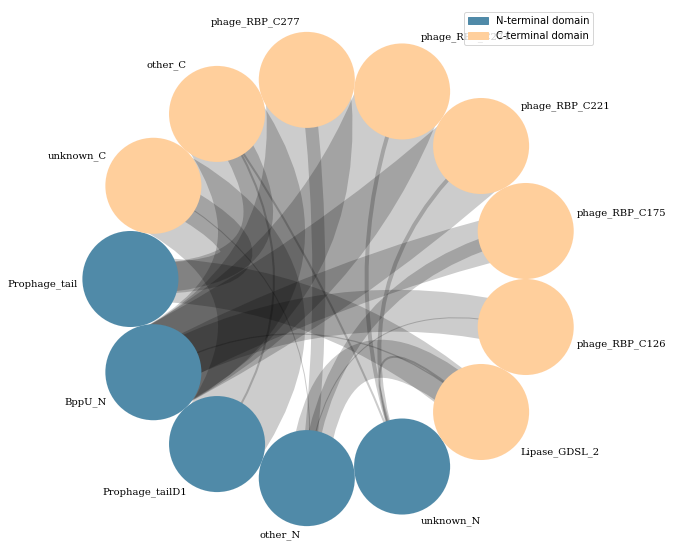

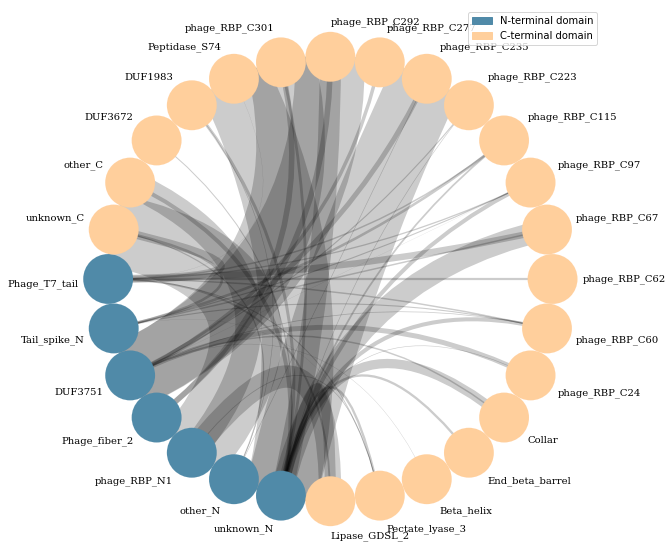

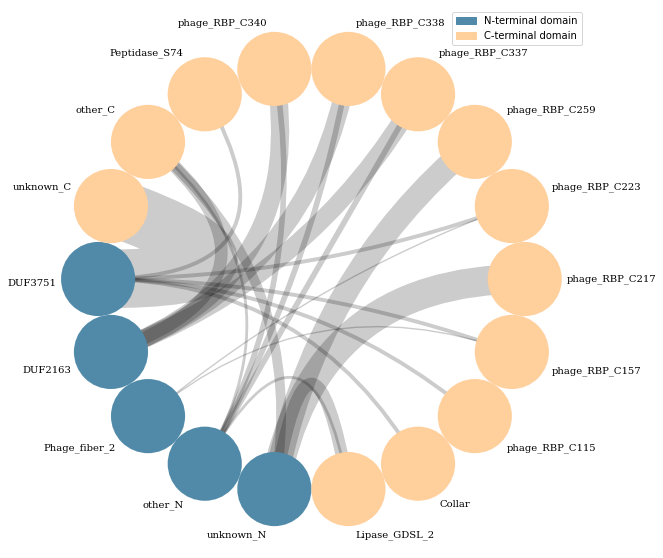

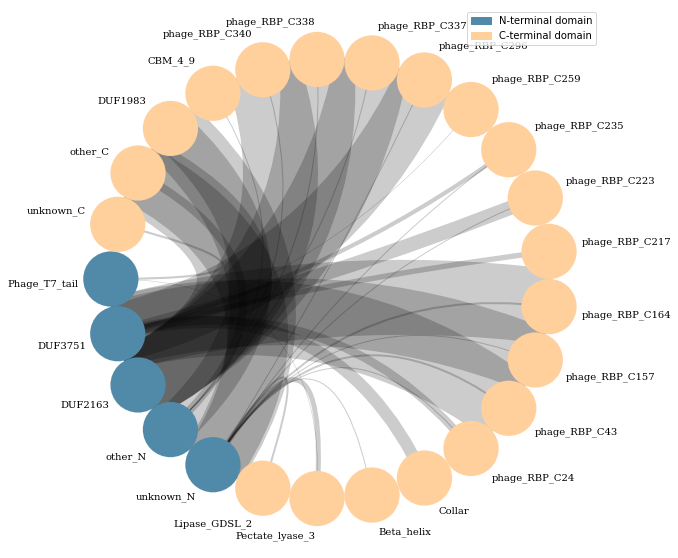

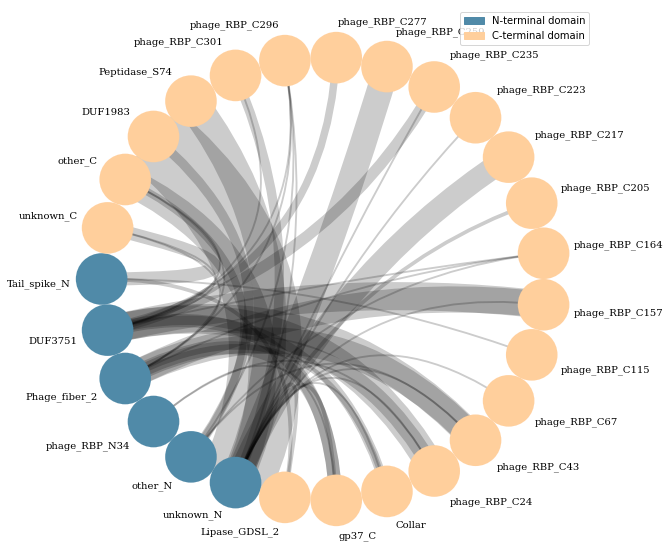

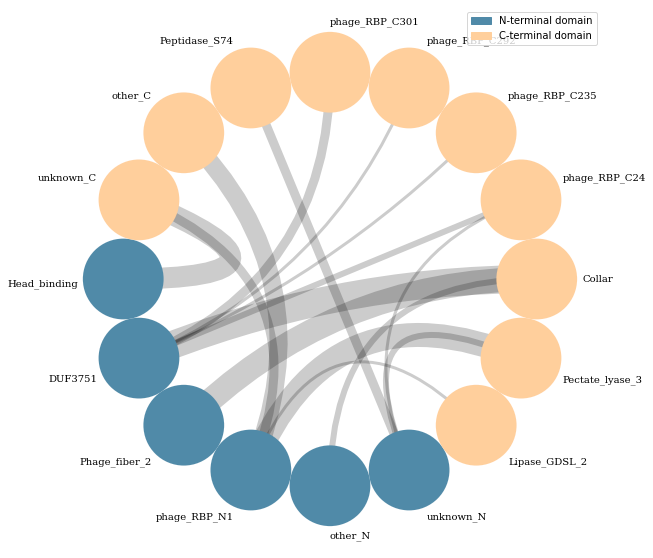

In [8]:
species = ['enterococcus_faecium', 'staphylococcus_aureus', 'klebsiella_pneumoniae', 'acinetobacter_baumannii', 
          'pseudomonas_aeruginosa', 'enterobacter_cloacae', 'enterobacter_aerogenes']
for sp in species:
    indices = RBPs.host == sp
    sequences_sp = RBPs.sequence[indices]
    exu.domain_cluster_graph(hmm_path, pfam_db, sequences_sp, filename='/Users/Dimi/Desktop/domains_circos_'+sp+'.png')

Now the question is: can we identify combinations that are unique to some species or that occur more often in some species versus others?

As a reference, the following clusters were initially filtered: N_1, C_120, C_143, C_175, C_221, C_234, C_237, C_271, C_277. These are the clusters we will pay extra attention to. We should also be wary of unknown-unknown combinations and other-unknown or unknown-other combinations.

##### E. faecium
At first glance, the circos graph for E. faecium appears dense. Many different combinations are identified. At the N-terminus, most combinations are with Prophage_tail, BppU_N and other_N. At the side of the C-terminus, we notice a lot of phage_RBP_C143, phage_RBP_C249, phage_RBP_C321 and other_C. The combinations that occur most frequently are (Prophage_tail + phage_RBP_C249), (BppU_N + phage_RBP_C321), (Prophage_tail + other_C), (other_N + phage_RBP_C143) and (other_N + phage_RBP_C120). We also notice very few unknown_C, which is a good thing, but quite a few other_C, which hints at the possibility of adding more known Pfam domains to the curated RBP list. We also notice some (other_N + other_C) combinations. We do not however notice any unknown+unknown, other+unknown or unknown+other combinations, which is good. Additionally, looking at this circos graph, none of the later added clusters look suspicious. The only sequences we could filter here are the (other_N + other_C) combinations.

##### S. aureus
For S. aureus, the first glance of the graph looks quite similar to E. faecium. Here, the one N-terminal building block that is present most often is BppU_N, followed by Prophage_tailD1 and Prophage_tail. At the C-terminus, we see a lot of C221, C271 and C277; in addition to other_C and unknown_C. Interestingly, the three custom built HMMs are all mostly linked to BppU_N. Some sequences seem to have a (unknown_N + other_C) combination, which might seem at first odd as to how it got in the dataset in the first place. But this could actually be a (unknown_N + Lipase_GDSL_2 + other_C) combination, we cannot see those threefold combinations from the circos graphs. Same with a (other_N + unknown_C) combination that could also be a (Prophage_tailD1 + other_N + unknown_C) combination. This is something we can account for in the final filtering below.

##### K. pneumoniae
Here we directly notice the many unknown_N occurences, which was already obvious from the heatmap. To put this into perspective, about 50% of the sequences have an unknown_N block. Most of these unknown_N are linked to C235, which itself is only seldom linked with DUF3751. This could be a block that we filter from the final selection. One other thing we notice is that N1 is mostly linked with unknown_C and other_C and only sometimes linked with Lipase_GDSL_2. Instead of completely discarding those sequences, we can also opt to discard the combinations that we think are dubious (N1 + unknown_C).

##### A. baumannii
Here, DUF3751, DUF2163 and unknown_N are the most occurring at the N-terminus. Two suspicious combinations we see are (unknown_N + **phage_RBP_C217**) and (unknown_N + **phage_RBP_C259**). Both C-terminal HMMs are not related to any other combination! The question now is, do we delete those? As they were not denoted as being suspicious by BLAST results.

##### P. aeruginosa
For P. aeruginosa we immediately notice the DUF3751 and DUF2163 that occur most often, followed by the unknown_N domain. We also see that these are combined with a variety of C-terminal building blocks, mostly custom built ones. This shows a nice example of HGT, but at the same time, we can notice that the combinations with DUF3751 are mostly distinct from the combinations with DUF2163 (groups of phages targeting other strains?). We also notice very few unknown_C, which is a sign that are constructed HMMs capture the C-terminal blocks very well (but in contrast, most of the C-terminal Pfam domains rarely occur).

##### E. cloacae
This is the second species for which we notice many unknown_N, followed by Phage_fiber_2 and DUF3751. One particular suspicious combo that we notice is (unknown_N + C67), as the **C67** does not occur in combination with any other N-terminal block. Same for **C205, C217, C223 and C259**. Of note, both C217 and C223 are connected to DUF3751 for P. aeruginosa.

##### E. aerogenes
Here, DUF3751 and N1 seem to be most occurring at the N-terminus, and three combinations that occur most often are (DUF3751 + Collar), (Phage_fiber_2 + Collar) and (N1 + Pectate_lyase_3). We do not notice any particularly suspicious combination.

### 6 - Construct final RBPbase

In [9]:
# define the paths and RBP building blocks (first all N-term, then C-term, then chaps)
N_blocks = ['Phage_T7_tail','Tail_spike_N','Prophage_tail','BppU_N','Mtd_N','Head_binding','DUF3751','End_N_terminal', 
           'phage_tail_N','Prophage_tailD1','DUF2163','Phage_fiber_2','phage_RBP_N1','phage_RBP_N4','phage_RBP_N26',
           'phage_RBP_N28','phage_RBP_N34','phage_RBP_N45']       
C_blocks = ['Lipase_GDSL_2','Pectate_lyase_3','gp37_C','Beta_helix','Gp58','End_beta_propel','End_tail_spike', 
           'End_beta_barrel','PhageP22-tail','Phage_spike_2','gp12-short_mid','Collar', 'phage_RBP_C2', 
           'phage_RBP_C10','phage_RBP_C24','phage_RBP_C43','phage_RBP_C59','phage_RBP_C60','phage_RBP_C62',
            'phage_RBP_C67','phage_RBP_C79','phage_RBP_C97','phage_RBP_C111','phage_RBP_C115','phage_RBP_C120',
            'phage_RBP_C126','phage_RBP_C138','phage_RBP_C143','phage_RBP_C157','phage_RBP_C164','phage_RBP_C175',
            'phage_RBP_C180','phage_RBP_C205','phage_RBP_C217','phage_RBP_C220','phage_RBP_C221','phage_RBP_C223',
            'phage_RBP_C234','phage_RBP_C235','phage_RBP_C237','phage_RBP_C249','phage_RBP_C259','phage_RBP_C267',
            'phage_RBP_C271','phage_RBP_C277','phage_RBP_C281','phage_RBP_C292','phage_RBP_C293','phage_RBP_C296', 
            'phage_RBP_C300','phage_RBP_C301','phage_RBP_C319','phage_RBP_C320','phage_RBP_C321','phage_RBP_C326', 
            'phage_RBP_C331','phage_RBP_C337','phage_RBP_C338','phage_RBP_C340',
           'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']

bar = tqdm(total=len(RBPs.sequence), leave=True)
N_list = []
C_list = []
for i, sequence in enumerate(RBPs['sequence']):
    N_sequence = []
    C_sequence = []
    domains, scores, biases, ranges = exu.gene_domain_scan(hmm_path, pfam_db, [sequence], threshold=18)
    for j, dom in enumerate(domains):
        OM_score = math.floor(math.log(scores[j], 10)) # order of magnitude
        OM_bias = math.floor(math.log(biases[j]+0.00001, 10))
        
        # N-terminal block
        if (OM_score > OM_bias) and (dom in N_blocks):
            N_sequence.append(dom)
        
        # C-terminal block
        elif (OM_score > OM_bias) and (dom in C_blocks) and (scores[j] >= 25):
            C_sequence.append(dom)
        
        # other block
        elif (OM_score > OM_bias) and (dom not in N_blocks) and (dom not in C_blocks):
            if ranges[j][1] <= 200:
                N_sequence.append('other')
            elif (ranges[j][1] > 200) and (scores[j] >= 25):
                C_sequence.append('other')
            
            
    # add to the global list
    N_list.append(N_sequence)
    C_list.append(C_sequence)
    
    # update bar
    bar.update(1)
bar.close()

# add to dataframe
RBPs['N_blocks'] = N_list
RBPs['C_blocks'] = C_list

  0%|          | 0/3933 [00:00<?, ?it/s]

In [48]:
to_delete = []
N_blocks = ['Phage_T7_tail','Tail_spike_N','Prophage_tail','BppU_N','Mtd_N','Head_binding','DUF3751','End_N_terminal', 
           'phage_tail_N','Prophage_tailD1','DUF2163','Phage_fiber_2','phage_RBP_N1','phage_RBP_N4','phage_RBP_N26',
           'phage_RBP_N28','phage_RBP_N34','phage_RBP_N45']       
C_blocks = ['Lipase_GDSL_2','Pectate_lyase_3','gp37_C','Beta_helix','Gp58','End_beta_propel','End_tail_spike', 
           'End_beta_barrel','PhageP22-tail','Phage_spike_2','gp12-short_mid','Collar', 'phage_RBP_C2', 
           'phage_RBP_C10','phage_RBP_C24','phage_RBP_C43','phage_RBP_C59','phage_RBP_C60','phage_RBP_C62',
            'phage_RBP_C67','phage_RBP_C79','phage_RBP_C97','phage_RBP_C111','phage_RBP_C115','phage_RBP_C120',
            'phage_RBP_C126','phage_RBP_C138','phage_RBP_C143','phage_RBP_C157','phage_RBP_C164','phage_RBP_C175',
            'phage_RBP_C180','phage_RBP_C205','phage_RBP_C217','phage_RBP_C220','phage_RBP_C221','phage_RBP_C223',
            'phage_RBP_C234','phage_RBP_C235','phage_RBP_C237','phage_RBP_C249','phage_RBP_C259','phage_RBP_C267',
            'phage_RBP_C271','phage_RBP_C277','phage_RBP_C281','phage_RBP_C292','phage_RBP_C293','phage_RBP_C296', 
            'phage_RBP_C300','phage_RBP_C301','phage_RBP_C319','phage_RBP_C320','phage_RBP_C321','phage_RBP_C326', 
            'phage_RBP_C331','phage_RBP_C337','phage_RBP_C338','phage_RBP_C340',
           'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']
C_filter = ['phage_RBP_C67', 'phage_RBP_C205', 'phage_RBP_C217', 'phage_RBP_C223', 'phage_RBP_C259']

for i, N_sequence in enumerate(RBPs['N_blocks']):
    C_sequence = RBPs['C_blocks'][i]
    N_known = set(N_sequence).intersection(N_blocks)
    C_known = set(C_sequence).intersection(C_blocks)
    Ctofilter = set(C_sequence).intersection(C_filter)
    
    # none or only others found
    if (len(N_known) == 0) and (len(C_known) == 0):
        to_delete.append(i)
        
    # other at N_terminus combined with C67, C205, C217, C223 or C259 at C-terminus
    elif (len(N_sequence) == 1) and (N_sequence[0] == 'other') and (len(Ctofilter) > 0):
        to_delete.append(i)
        
    # none at N_terminus combined with C67, C205, C217, C223 or C259 at C-terminus
    elif (len(N_sequence) == 0) and (len(Ctofilter) > 0):
        to_delete.append(i)
        
# update final database
RBPs = RBPs.drop(to_delete)
RBPs = RBPs.reset_index(drop=True)
RBPs.to_csv('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/42_DATA/RBPbase_10521.csv', index=False)

In [49]:
RBPs.shape

(3844, 7)